<a href="https://colab.research.google.com/github/ju-ki/atma10/blob/master/exp10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!git clone https://github.com/facebookresearch/fastText.git
!pip install fastText xfeat category_encoders texthero  umap transformers MulticoreTSNE catboost
!rm -rf fastText

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.22 MiB | 1.46 MiB/s, done.
Resolving deltas: 100% (2417/2417), done.


In [3]:
import os 
import glob 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import texthero as hero
from fasttext import load_model
sns.set()
CODE_PATH = "/content/drive/MyDrive/my_pipeline/code/"
INPUT_PATH = "/content/drive/MyDrive/atma10_data/"
OUTPUT_PAHT = "/content/drive/MyDrive/atma10_data/submission/"


In [4]:
os.chdir(CODE_PATH)
from util import AbstractBaseBlock, WrapperBlock, read_csv
from feature_engine import *
from nlp_feature import *

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [5]:
train_df = read_csv("train", INPUT_PATH)
test_df = read_csv("test", INPUT_PATH)

run
run


In [6]:
class SubTitleFeatureBlock(AbstractBaseBlock):
  def __init__(self):
    return 

  def transform(self,input_df):
    for axis in ['h', 'w', 't', 'd']:
        column_name = f'size_{axis}'
        size_info = input_df['sub_title'].str.extract(r'{} (\d*|\d*\.\d*)(cm|mm)'.format(axis)) # 正規表現を使ってサイズを抽出
        size_info = size_info.rename(columns={0: column_name, 1: 'unit'})
        size_info[column_name] = size_info[column_name].replace('', np.nan).astype(float) # dtypeがobjectになってるのでfloatに直す
        size_info[column_name] = size_info.apply(lambda row: row[column_name] * 10 if row['unit'] == 'cm' else row[column_name], axis=1) # 　単位をmmに統一する
        input_df[column_name] = size_info[column_name] # trainにくっつける
    input_df.loc[input_df['object_id']=='81b0b69b11ad460a19fe', 'size_w'] = 78
    input_df['area'] = input_df['size_h']*input_df['size_w']
    input_df['volume'] = input_df['area']*input_df['size_d']
    input_df['H-W'] = input_df['size_h'] - input_df['size_w']
    return input_df[[ 'size_h', 'size_w', 'size_t', 'size_d','area','volume','H-W']]

In [7]:
SubTitleFeatureBlock().fit(train_df)
SubTitleFeatureBlock().transform(test_df)

,size_h,size_w,size_t,size_d,area,volume,H-W
0,167.0,108.0,NaN,NaN,18036.0,NaN,59.0
1,297.0,241.0,NaN,NaN,71577.0,NaN,56.0
2,270.0,215.0,NaN,NaN,58050.0,NaN,55.0
3,116.0,159.0,NaN,NaN,18444.0,NaN,-43.0
4,108.0,184.0,NaN,NaN,19872.0,NaN,-76.0
...,...,...,...,...,...,...,...
12003,32.0,51.0,NaN,NaN,1632.0,NaN,-19.0
12004,271.0,337.0,NaN,NaN,91327.0,NaN,-66.0
12005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12006,30.0,50.0,NaN,NaN,1500.0,NaN,-20.0


In [8]:
maker = pd.read_csv(INPUT_PATH + 'maker.csv')
train_df = pd.merge(train_df, maker, left_on="principal_maker", right_on="name", how="left")
test_df = pd.merge(test_df, maker, left_on="principal_maker", right_on="name", how="left")


train_df["acquisition_date"] = pd.to_datetime(train_df["acquisition_date"])
train_df["acquisition_date"] = train_df['acquisition_date'].dt.strftime("%Y")

test_df["acquisition_date"] = pd.to_datetime(test_df["acquisition_date"])
test_df["acquisition_date"] = test_df['acquisition_date'].dt.strftime("%Y")

train_df["date_of_birth"] = train_df["date_of_birth"].str[:4]
train_df["date_of_death"] = train_df["date_of_death"].str[:4]
train_df["date_of_birth"] = train_df["date_of_birth"].astype(float)
train_df["date_of_death"] = train_df["date_of_death"].astype(float)


test_df["date_of_birth"] = test_df["date_of_birth"].str[:4]
test_df["date_of_death"] = test_df["date_of_death"].str[:4]
test_df["date_of_birth"] = test_df["date_of_birth"].astype(float)
test_df["date_of_death"] = test_df["date_of_death"].astype(float)


train_df["age"] = train_df["date_of_death"].astype(float) - train_df["date_of_birth"].astype(float)
train_df["age"] = train_df["age"].fillna("NaN")
train_df["age"] = train_df["age"].astype(float)

test_df["age"] = test_df["date_of_death"].astype(float) - test_df["date_of_birth"].astype(float)
test_df["age"] = test_df["age"].fillna("NaN")
test_df["age"] = test_df["age"].astype(float)


train_df.loc[(train_df["age"] < 0.0) | (train_df["age"] > 100.0), "date_of_birth"] = "NaN"
train_df.loc[(train_df["age"] < 0.0) | (train_df["age"] > 100.0), "date_of_death"] = "NaN"
train_df.loc[(train_df["age"] < 0.0) | (train_df["age"] > 100.0), "age"] = "NaN"

test_df.loc[(test_df["age"] < 0.0) | (test_df["age"] > 100.0), "date_of_birth"] = "NaN"
test_df.loc[(test_df["age"] < 0.0) | (test_df["age"] > 100.0), "date_of_death"] = "NaN"
test_df.loc[(test_df["age"] < 0.0) | (test_df["age"] > 100.0), "age"] = "NaN"

train_df["age"] = train_df["age"].astype(float)
test_df["age"] = test_df["age"].astype(float)

train_df["date_of_birth"] = train_df["date_of_birth"].astype(float)
train_df["date_of_death"] = train_df["date_of_death"].astype(float)

test_df["date_of_birth"] = test_df["date_of_birth"].astype(float)
test_df["date_of_death"] = test_df["date_of_death"].astype(float)


#制作期間が長いほど名作なのでは
train_df["period_of_production"] = train_df["dating_year_late"].astype(float) - train_df["dating_year_early"].astype(float)
train_df["period_of_production"] = train_df["period_of_production"].fillna("NaN").astype(float)

#ここの期間が短い（遺作）は評価が高いのでは
train_df["period_between_death_year_and_late_year"] = train_df["date_of_death"].astype(float) - train_df["dating_year_late"].astype(float)
train_df["period_between_death_year_and_late_year"] = train_df["period_between_death_year_and_late_year"].fillna("NaN").astype(float)
#回収されるまでの期間が長ければ名作なのでは
train_df["period_between_acquistion_date_and_date_death"] = train_df["acquisition_date"].astype(float) - train_df["date_of_birth"].astype(float)
train_df["period_between_acquistion_date_and_date_death"] = train_df["period_between_acquistion_date_and_date_death"].fillna("NaN").astype(float)
#幼少期に書かれた作品は評価が良いのでは？
train_df["period_between_date_of_birth_and_dating_year_late"] = train_df["dating_year_late"].astype(float) - train_df["date_of_birth"].astype(float)
train_df["period_between_date_of_birth_and_dating_year_late"] = train_df["period_between_date_of_birth_and_dating_year_late"].fillna("NaN").astype(float)

#制作期間が長いほど名作なのでは
test_df["period_of_production"] = test_df["dating_year_late"].astype(float) - test_df["dating_year_early"].astype(float)
test_df["period_of_production"] = test_df["period_of_production"].fillna("NaN").astype(float)

#ここの期間が短い（遺作）は評価が高いのでは
test_df["period_between_death_year_and_late_year"] = test_df["date_of_death"].astype(float) - test_df["dating_year_late"].astype(float)
test_df["period_between_death_year_and_late_year"] = test_df["period_between_death_year_and_late_year"].fillna("NaN").astype(float)
#回収されるまでの期間が長ければ名作なのでは
test_df["period_between_acquistion_date_and_date_death"] = test_df["acquisition_date"].astype(float) - test_df["date_of_birth"].astype(float)
test_df["period_between_acquistion_date_and_date_death"] = test_df["period_between_acquistion_date_and_date_death"].fillna("NaN").astype(float)
#幼少期に書かれた作品は評価が良いのでは？
test_df["period_between_date_of_birth_and_dating_year_late"] = test_df["dating_year_late"].astype(float) - test_df["date_of_birth"].astype(float)
test_df["period_between_date_of_birth_and_dating_year_late"] = test_df["period_between_date_of_birth_and_dating_year_late"].fillna("NaN").astype(float)

train_df["last_work_vs_first_work"] = train_df["period_between_death_year_and_late_year"] - train_df["period_between_date_of_birth_and_dating_year_late"]
test_df["last_work_vs_first_work"] = test_df["period_between_death_year_and_late_year"] - test_df["period_between_date_of_birth_and_dating_year_late"]


train_df["is_coworking"] = train_df["period_between_death_year_and_late_year"].apply(lambda x : 1 if x < 0.0 else 0)
test_df["is_coworking"] = test_df["period_between_death_year_and_late_year"].apply(lambda x : 1 if x < 0.0 else 0)

In [9]:
import torch
import transformers
from transformers import BertTokenizer

class BertSequenceVectorizer:
    def __init__(self,model_name):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = model_name
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 128


    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()

In [31]:
from tqdm import tqdm
tqdm.pandas()
# text_col=['title','description','long_title','more_title','acquisition_credit_line']

# for col in text_col:
#     train_df[col].fillna('NaN',inplace=True)
#     test_df[col].fillna('NaN',inplace=True)

#     b = BertSequenceVectorizer("bert-base-multilingual-cased")   
#     train_df[col] = train_df[col].progress_apply(lambda x:b.vectorize(x))
#     test_df[col] = test_df[col].progress_apply(lambda x:b.vectorize(x))

#     pd.DataFrame(np.stack(train_df[col])).add_prefix('Bert_multi_').to_pickle(INPUT_PATH + f'Bert_multi_train_{col}.pickle')
#     pd.DataFrame(np.stack(test_df[col])).add_prefix('Bert_multi_').to_pickle(INPUT_PATH + f'Bert_multi_test_{col}.pickle')   

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [11]:
from sklearn.decomposition import PCA, TruncatedSVD

class BertMultiPCABlock(AbstractBaseBlock):
  def __init__(self, col, dim):
    self.col = col
    self.dim = dim
    self.pca = None

  def fit(self, input_df):
    train_df = pd.read_pickle(INPUT_PATH + f"Bert_multi_train_{self.col}.pickle")
    test_df = pd.read_pickle(INPUT_PATH + f"Bert_multi_test_{self.col}.pickle")
    whole_df = pd.concat([train_df, test_df], axis=0)
    pca = PCA(self.dim, random_state=0)
    pca.fit(whole_df)
    self.pca = pca

    train_df = pd.DataFrame(pca.transform(train_df))
    print(f"累積寄与率:{np.sum(pca.explained_variance_ratio_)}")
    return train_df.add_prefix(f"pca_multi_{self.col}_")

  def transform(self, input_df):
    test_df = pd.read_pickle(INPUT_PATH + f"Bert_multi_test_{self.col}.pickle")
    test_df = pd.DataFrame(self.pca.transform(test_df))
    return test_df.add_prefix(f"pca_multi_{self.col}_")


In [12]:
BertMultiPCABlock("title", dim=256).fit(train_df)

累積寄与率:0.9477313160896301


,pca_multi_title_0,pca_multi_title_1,pca_multi_title_2,pca_multi_title_3,pca_multi_title_4,pca_multi_title_5,pca_multi_title_6,pca_multi_title_7,pca_multi_title_8,pca_multi_title_9,pca_multi_title_10,pca_multi_title_11,pca_multi_title_12,pca_multi_title_13,pca_multi_title_14,pca_multi_title_15,pca_multi_title_16,pca_multi_title_17,pca_multi_title_18,pca_multi_title_19,pca_multi_title_20,pca_multi_title_21,pca_multi_title_22,pca_multi_title_23,pca_multi_title_24,pca_multi_title_25,pca_multi_title_26,pca_multi_title_27,pca_multi_title_28,pca_multi_title_29,pca_multi_title_30,pca_multi_title_31,pca_multi_title_32,pca_multi_title_33,pca_multi_title_34,pca_multi_title_35,pca_multi_title_36,pca_multi_title_37,pca_multi_title_38,pca_multi_title_39,...,pca_multi_title_216,pca_multi_title_217,pca_multi_title_218,pca_multi_title_219,pca_multi_title_220,pca_multi_title_221,pca_multi_title_222,pca_multi_title_223,pca_multi_title_224,pca_multi_title_225,pca_multi_title_226,pca_multi_title_227,pca_multi_title_228,pca_multi_title_229,pca_multi_title_230,pca_multi_title_231,pca_multi_title_232,pca_multi_title_233,pca_multi_title_234,pca_multi_title_235,pca_multi_title_236,pca_multi_title_237,pca_multi_title_238,pca_multi_title_239,pca_multi_title_240,pca_multi_title_241,pca_multi_title_242,pca_multi_title_243,pca_multi_title_244,pca_multi_title_245,pca_multi_title_246,pca_multi_title_247,pca_multi_title_248,pca_multi_title_249,pca_multi_title_250,pca_multi_title_251,pca_multi_title_252,pca_multi_title_253,pca_multi_title_254,pca_multi_title_255
0,10.899082,-2.481870,0.484845,4.094805,1.758194,0.277830,0.630968,1.892064,1.630193,-1.023263,0.860297,-0.802734,0.646716,-0.598311,-0.967270,0.238118,0.663790,-0.460077,-1.419749,0.371095,-0.060814,-0.246120,-0.063205,0.125362,-0.939483,-0.097388,1.009518,-1.446611,-0.521044,0.439035,0.139229,-0.388325,-0.213126,0.809537,0.330749,-0.248293,-1.133381,-0.037472,1.246799,-0.093074,...,0.295056,0.121648,0.066516,-0.439056,0.097375,-0.021437,-0.272111,-0.086759,0.087149,-0.032803,-0.136394,-0.171495,0.389598,-0.364013,-0.177915,-0.262389,-0.001178,-0.267953,0.202842,0.083344,0.118387,-0.111008,0.134579,0.122457,-0.203289,-0.060909,0.233162,0.035662,0.039036,-0.068542,-0.001672,0.033540,0.134194,-0.101103,0.031589,-0.148578,-0.260516,-0.213701,-0.161547,-0.352741
1,-1.034533,-1.386723,-0.552982,0.083008,0.163265,0.382729,0.638819,-0.448951,-0.390031,0.758841,-0.314972,0.186570,0.381065,0.757119,0.844470,-0.059129,-0.002185,-0.016277,-0.285078,-0.153513,0.004508,-0.157164,0.091898,0.531838,-0.090550,0.559405,0.304373,-0.344269,0.071626,0.124257,0.198268,0.006210,-0.167156,0.324712,0.071430,-0.232567,-0.048668,0.312958,-0.196851,-0.084800,...,0.137177,-0.052218,0.177788,-0.103782,-0.056113,-0.123150,-0.015761,-0.072189,-0.045780,0.005831,0.028022,0.028871,-0.074375,0.006453,0.126721,0.102520,-0.000954,-0.015937,-0.157790,0.088464,0.013289,0.078699,0.101480,0.095651,-0.020746,0.124909,-0.051842,0.068697,-0.022448,0.016635,0.120268,-0.001144,0.048583,0.030201,-0.039068,-0.029947,-0.105658,0.017099,-0.036271,-0.056627
2,1.134993,3.250011,-2.999882,-0.667305,-0.539548,-0.044403,-0.268924,0.000201,0.647223,0.555577,0.289311,-0.309950,-0.301205,0.327889,0.363803,-0.428372,0.166475,0.067203,0.277455,-0.171190,-0.044630,-0.402193,-0.124918,0.089570,0.332374,-0.036516,0.206707,-0.018454,-0.048063,0.283359,0.107640,-0.008360,0.206320,0.245336,-0.336430,0.105076,0.206046,-0.069668,0.258937,-0.105372,...,0.014469,-0.042396,0.019791,-0.067518,0.014066,0.080977,0.024620,-0.009527,-0.050070,0.017161,-0.045839,0.059390,-0.048370,0.076416,0.059571,0.092316,-0.042793,-0.006586,0.024954,-0.026437,-0.011827,-0.025676,0.027484,-0.030529,-0.028596,0.008198,0.040012,0.037006,-0.045903,0.097066,-0.086789,-0.072630,-0.086179,-0.057595,-0.109631,0.036262,-0.059749,0.018643,0.025359,-0.004394
3,4.377326,-2.510393,-0.207143,0.094696,0.129753,0.290896,-0.217596,0.246551,0.952361,-0.875543,-0.512177,-0.612333,1.503522,-1.025288,0.052953,

In [13]:
class BertMultiSVDBlock(AbstractBaseBlock):
  def __init__(self, col, dim):
    self.col = col
    self.dim = dim
    self.svd = None

  def fit(self, input_df):
    train_df = pd.read_pickle(INPUT_PATH + f"Bert_multi_train_{self.col}.pickle")
    test_df = pd.read_pickle(INPUT_PATH + f"Bert_multi_test_{self.col}.pickle")
    whole_df = pd.concat([train_df, test_df], axis=0)
    svd = TruncatedSVD(self.dim, random_state=0)
    svd.fit(whole_df)
    self.svd = svd

    train_df = pd.DataFrame(svd.transform(train_df))
    print(f"累積寄与率:{np.sum(svd.explained_variance_ratio_)}")
    return train_df.add_prefix(f"svd_multi_{self.col}_")

  def transform(self, input_df):
    test_df = pd.read_pickle(INPUT_PATH + f"Bert_multi_test_{self.col}.pickle")
    test_df = pd.DataFrame(self.svd.transform(test_df))
    return test_df.add_prefix(f"svd_multi_{self.col}_")

In [14]:
class CollectBlock(AbstractBaseBlock):
    def __init__(self, dim):
        self.meta = None
        self.dim = dim
    
    def fit(self,input_df):
        collect = read_csv('object_collection.csv', INPUT_PATH)
        tab = pd.crosstab(collect['object_id'],collect['name'])
        pca = PCA(self.dim,random_state=0)
        self.meta = pd.DataFrame(pca.fit_transform(tab),index=tab.index)
        print(f"累積寄与率：{np.sum(pca.explained_variance_ratio_)}")
        return self.transform(input_df)

    def transform(self, input_df):
        return pd.merge(input_df['object_id'],self.meta,on='object_id',how='left').drop(columns='object_id')\
            .add_prefix('Collect_')

In [15]:
import re
class PersonBlock(AbstractBaseBlock):
    def __init__(self):
        self.meta = None
    
    def fit(self,input_df):
        person = read_csv('historical_person', INPUT_PATH)
        person['name'] = person['name'].apply(lambda x : re.sub('[\[\]\,\)\(\.\}\{\-]','',x))
        names = person['name'].value_counts().head(10).index
        self.meta = pd.crosstab(person['object_id'],person['name'])[names].reset_index()
        return self.transform(input_df)

    def transform(self, input_df):
        return pd.merge(input_df['object_id'],self.meta,on='object_id',how='left').drop(columns='object_id')

In [16]:
class TechBlock(AbstractBaseBlock):
    def __init__(self,dim):
        self.dim = dim
        self.meta = None

    def fit(self,input_df):
        tech = read_csv('technique', INPUT_PATH)
        pca = PCA(self.dim,random_state=0)
        tab = pd.crosstab(tech['object_id'],tech['name'])
        self.meta = pd.DataFrame(pca.fit_transform(tab),index=tab.index)
        print(f"累積寄与率：{np.sum(pca.explained_variance_ratio_)}")
        return self.transform(input_df)

    def transform(self, input_df):
        return pd.merge(input_df['object_id'],self.meta,on='object_id',how='left').drop(columns='object_id').add_prefix("pca_tech_")

In [17]:
from PIL import ImageColor
class ColorBlock(AbstractBaseBlock):
    def __init__(self,num):
        self.meta = None
        self.num = num
    
    def fit(self,input_df):
        color_df = read_csv('color', INPUT_PATH)
        color_df[['R','G','B']] = pd.DataFrame(color_df['hex'].str.strip().map(ImageColor.getrgb).values.tolist(), columns=['R', 'G', 'B'])
        self.meta = color_df.groupby('object_id')['percentage','R','G','B'].apply(lambda x:x.sort_values(['percentage'],ascending=False).iloc[self.num]).reset_index()
        return self.transform(input_df)
    
    def transform(self, input_df):
        return pd.merge(input_df['object_id'],self.meta,on='object_id',how='left')\
            .drop(columns='object_id').add_suffix('_' + str(self.num))

In [18]:
ColorBlock(5).fit(train_df)

run


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,percentage_5,R_5,G_5,B_5
0,3.0,179.0,168.0,136.0
1,NaN,NaN,NaN,NaN
2,7.0,76.0,55.0,36.0
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
12021,NaN,NaN,NaN,NaN
12022,0.0,88.0,76.0,52.0
12023,NaN,NaN,NaN,NaN
12024,3.0,73.0,68.0,55.0


In [19]:
class MaterialBlock(AbstractBaseBlock):
    def __init__(self, dim):
        self.meta = None
        self.dim = dim

    def fit(self,input_df):
        pca =PCA(self.dim,random_state=0)
        material = read_csv('material.csv', INPUT_PATH)
        tab = pd.crosstab(material['object_id'],material['name'])
        self.meta = pd.DataFrame(pca.fit_transform(tab),index=tab.index)
        print(f"累積寄与率：{np.sum(pca.explained_variance_ratio_)}")
        return self.transform(input_df)

    def transform(self,input_df):
        return pd.merge(input_df['object_id'],self.meta,on='object_id',how='left').drop(columns='object_id')\
            .add_prefix('PCA_Material_')

In [20]:
MaterialBlock(20).fit(train_df)

run
累積寄与率：0.9888224132834856


,PCA_Material_0,PCA_Material_1,PCA_Material_2,PCA_Material_3,PCA_Material_4,PCA_Material_5,PCA_Material_6,PCA_Material_7,PCA_Material_8,PCA_Material_9,PCA_Material_10,PCA_Material_11,PCA_Material_12,PCA_Material_13,PCA_Material_14,PCA_Material_15,PCA_Material_16,PCA_Material_17,PCA_Material_18,PCA_Material_19
0,0.591230,1.098621,0.362203,-0.513145,-0.067547,0.022472,-0.030050,0.012409,0.010201,-0.008064,0.003388,-0.002039,0.000170,0.000426,-0.001813,-0.002393,-0.000454,0.000245,0.000237,0.000270
1,0.629325,-0.353424,-0.513485,-0.191814,-0.145979,-0.073440,0.019103,-0.029796,0.024326,-0.000511,-0.000578,-0.000443,-0.005318,-0.009956,-0.006371,0.000366,-0.001918,-0.000648,-0.002635,-0.003726
2,0.141636,-0.967574,0.563165,0.141559,-0.153080,0.232727,-0.044839,0.064897,-0.056086,-0.000801,-0.001937,0.000885,-0.009628,0.020320,0.006412,0.002966,0.003014,-0.000626,0.006770,0.001534
3,0.591230,1.098621,0.362203,-0.513145,-0.067547,0.022472,-0.030050,0.012409,0.010201,-0.008064,0.003388,-0.002039,0.000170,0.000426,-0.001813,-0.002393,-0.000454,0.000245,0.000237,0.000270
4,0.539901,1.001907,-0.128088,0.800279,-0.215955,0.035445,-0.036165,0.012574,0.007153,-0.006347,-0.005511,0.000564,0.000269,0.001029,-0.002069,-0.001634,-0.007742,-0.003737,-0.009150,0.000319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,-0.607358,0.022765,0.000882,-0.002162,0.018767,-0.044767,0.008689,-0.013065,0.014107,-0.000282,-0.000287,0.000268,0.000752,-0.004420,-0.004819,-0.001414,-0.000358,-0.000957,-0.001530,-0.000576
12022,-0.607358,0.022765,0.000882,-0.002162,0.018767,-0.044767,0.008689,-0.013065,0.014107,-0.000282,-0.000287,0.000268,0.000752,-0.004420,-0.004819,-0.001414,-0.000358,-0.000957,-0.001530,-0.000576
12023,-0.607358,0.022765,0.000882,-0.002162,0.018767,-0.044767,0.008689,-0.013065,0.014107,-0.000282,-0.000287,0.000268,0.000752,-0.004420,-0.004819,-0.001414,-0.000358,-0.000957,-0.001530,-0.000576
12024,-0.607358,0.022765,0.000882,-0.002162,0.018767,-0.044767,0.008689,-0.013065,0.014107,-0.000282,-0.000287,0.000268,0.000752,-0.004420,-0.004819,-0.001414,-0.000358,-0.000957,-0.001530,-0.000576


In [35]:

from gensim.models import word2vec

model_size = {
    "material": 20,
    "technique": 8,
    "collection": 3,
    "material_collection": 20,
    "material_technique": 20,
    "collection_technique": 10,
    "material_collection_technique": 25
}


class Word2VecBlock(AbstractBaseBlock):
  def __init__(self, model_size:tuple):
    self.model_size = model_size

  def fit(self, input_df, y=None):
    material_df = read_csv("material", INPUT_PATH)
    technique_df = read_csv("technique", INPUT_PATH)
    collection = read_csv("object_collection", INPUT_PATH)

    mat_col = pd.concat([material_df, collection], axis=0).reset_index(drop=True)
    mat_tec = pd.concat([material_df, technique_df], axis=0).reset_index(drop=True)
    col_tec = pd.concat([collection, technique_df], axis=0).reset_index(drop=True)
    mat_col_tec = pd.concat([material_df, collection, technique_df], axis=0).reset_index(drop=True)

    w2v_dfs = []
    for df, df_name in zip(
            [
                material_df, collection, technique_df,
                mat_col, mat_tec, col_tec, mat_col_tec
            ], [
                "material", "collection", "technique",
                "material_collection",
                "material_technique",
                "collection_technique",
                "material_collection_technique"
            ]):
        df_group = df.groupby("object_id")["name"].apply(list).reset_index()
        # Word2Vecの学習
        w2v_model = word2vec.Word2Vec(df_group["name"].values.tolist(),
                                      size=model_size[df_name],
                                      min_count=1,
                                      window=1,
                                      iter=100)

        # 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって文章ベクトルにする
        sentence_vectors = df_group["name"].progress_apply(
            lambda x: np.mean([w2v_model.wv[e] for e in x], axis=0))
        sentence_vectors = np.vstack([x for x in sentence_vectors])
        sentence_vector_df = pd.DataFrame(sentence_vectors,
                                          columns=[f"{df_name}_w2v_{i}"
                                                  for i in range(model_size[df_name])])
        sentence_vector_df.index = df_group["object_id"]
        w2v_dfs.append(sentence_vector_df)

    tmp_2 = pd.merge(w2v_dfs[0], w2v_dfs[1], on='object_id', how="left")
    tmp_3 = pd.merge(w2v_dfs[2], w2v_dfs[3], on='object_id', how="left")
    tmp_4 = pd.merge(w2v_dfs[4], w2v_dfs[5], on='object_id', how="left")
    tmp_5 = pd.merge(tmp_2, w2v_dfs[6], on="object_id", how="left")
    tmp_2 = pd.merge(tmp_3, tmp_4, on="object_id", how="left")
    self._df = pd.merge(tmp_5, tmp_2, on="object_id", how="left")

    return self.transform(input_df)
      
  def transform(self, input_df):
    out_df = pd.DataFrame()
    out_df = left_join(input_df, self._df)
    return out_df
OBJECT_ID = "object_id"
def left_join(left, right, on=OBJECT_ID):
    if isinstance(left, pd.DataFrame):
        left = left[on]
    return pd.merge(left, right, on=on, how='left').drop(columns=[on])

In [36]:
from time import time
from tqdm import tqdm
from contextlib import contextmanager

def get_function(block,is_train):
    s = mapping ={
        True:'fit',
        False:'transform'
    }.get(is_train)
    return getattr(block,s)

def to_feature(input_df,remain_df,blocks,is_train=False):
    out_df = remain_df
    
    for block in tqdm(blocks,total=len(blocks)):
        func = get_function(block,is_train)
        
        with timer(prefix='create' + str(block) + ' '):
            _df = func(input_df)
        print(len(_df), len(input_df))
        assert len(_df) == len(input_df),func._name_
        out_df = pd.concat([out_df,_df],axis=1)
    return out_df

@contextmanager
def timer(logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None):
  if prefix: format_str = str(prefix) + format_str
  if suffix: format_str = format_str + str(suffix)
  start = time()
  yield
  d = time() - start
  out_str = format_str.format(d)
  if logger:
    logger.info(out_str)
  else:
    print(out_str)

In [66]:

add_feature_block = [
                     GetLanguageLabel("title"),
                     GetLanguageLabel("description"),
                     GetLanguageLabel("long_title"),
                     StringLengthBlock("title"),
                     StringLengthBlock("description"),
                     StringLengthBlock("acquisition_credit_line"),
                     StringLengthBlock("long_title"),
                     StringLengthBlock("more_title"),
                     StringLengthBlock("sub_title"),

]

train_feat_df = to_feature(train_df, train_df, add_feature_block, is_train=True)
test_feat_df = to_feature(test_df, test_df, add_feature_block, is_train=False)
print(train_df.shape, test_df.shape)






  0%|          | 0/9 [00:00<?, ?it/s]Warning : `load_model` does not return WordVectorModel or SupervisedModel any more, but a `FastText` object which is very similar.





 11%|█         | 1/9 [00:00<00:03,  2.54it/s]

create<nlp_feature.GetLanguageLabel object at 0x7f9272b5f4d0> 0.386[s]
12026 12026







 22%|██▏       | 2/9 [00:00<00:03,  2.32it/s]

create<nlp_feature.GetLanguageLabel object at 0x7f9272b5f490> 0.495[s]
12026 12026







 33%|███▎      | 3/9 [00:01<00:02,  2.27it/s]




100%|██████████| 9/9 [00:01<00:00,  6.02it/s]





  0%|          | 0/9 [00:00<?, ?it/s]

create<nlp_feature.GetLanguageLabel object at 0x7f9272b5f450> 0.444[s]
12026 12026
create<nlp_feature.StringLengthBlock object at 0x7f9272b5f410> 0.007[s]
12026 12026
create<nlp_feature.StringLengthBlock object at 0x7f9272b5f3d0> 0.005[s]
12026 12026
create<nlp_feature.StringLengthBlock object at 0x7f9272b5f350> 0.004[s]
12026 12026
create<nlp_feature.StringLengthBlock object at 0x7f9272b5f390> 0.005[s]
12026 12026
create<nlp_feature.StringLengthBlock object at 0x7f9272b5f310> 0.005[s]
12026 12026
create<nlp_feature.StringLengthBlock object at 0x7f9272b5f2d0> 0.005[s]
12026 12026







 11%|█         | 1/9 [00:00<00:01,  4.96it/s]

create<nlp_feature.GetLanguageLabel object at 0x7f9272b5f4d0> 0.195[s]
12008 12008







 22%|██▏       | 2/9 [00:00<00:01,  4.26it/s]

create<nlp_feature.GetLanguageLabel object at 0x7f9272b5f490> 0.292[s]
12008 12008







 33%|███▎      | 3/9 [00:00<00:01,  4.23it/s]




100%|██████████| 9/9 [00:00<00:00, 10.30it/s]

create<nlp_feature.GetLanguageLabel object at 0x7f9272b5f450> 0.219[s]
12008 12008
create<nlp_feature.StringLengthBlock object at 0x7f9272b5f410> 0.006[s]
12008 12008
create<nlp_feature.StringLengthBlock object at 0x7f9272b5f3d0> 0.006[s]
12008 12008
create<nlp_feature.StringLengthBlock object at 0x7f9272b5f350> 0.005[s]
12008 12008
create<nlp_feature.StringLengthBlock object at 0x7f9272b5f390> 0.005[s]
12008 12008
create<nlp_feature.StringLengthBlock object at 0x7f9272b5f310> 0.005[s]
12008 12008
create<nlp_feature.StringLengthBlock object at 0x7f9272b5f2d0> 0.005[s]
12008 12008
(12026, 39) (12008, 38)


In [67]:
process_blocks = [
                 LabelEncodingBlock("acquisition_method"),
                 LabelEncodingBlock("principal_maker"),
                 LabelEncodingBlock("lang_label_title"),
                 LabelEncodingBlock("lang_label_description"),
                 LabelEncodingBlock("lang_label_long_title"),
                 LabelEncodingBlock("title"),
                 LabelEncodingBlock("description"),
                 CountEncodingBlock("acquisition_method"),
                 CountEncodingBlock("principal_maker"),
                 CountEncodingBlock("lang_label_title"),
                 CountEncodingBlock("lang_label_description"),
                 CountEncodingBlock("title"),
                 CountEncodingBlock("description"),
                 TargetEncodingBlock(cols="principal_maker", target="likes"),
                 TfidfBlock("title"),
                 TfidfBlock("description"),
                 TfidfBlock("more_title"),
                 TfidfBlock("long_title"),
                 TfidfBlock("acquisition_credit_line"),
                 BertMultiPCABlock("title", 256),
                 BertMultiPCABlock("long_title", 256),
                 BertMultiPCABlock("more_title", 256),
                 BertMultiPCABlock("description", 256),
                 BertMultiPCABlock("acquisition_credit_line", 256),
                 TechBlock(8),
                 MaterialBlock(20),
                 PersonBlock(),
                 CollectBlock(3),
                 ColorBlock(3),
                 Word2VecBlock(model_size), 
                #  AggregationBlock(group_key="principal_maker", 
                #                    group_values=["area", "volume", "H-W",
                #                                   "period_of_production", "period_between_acquistion_date_and_date_death",
                #                                   "period_between_death_year_and_late_year", "last_work_vs_first_work"],
                #                    agg_methods=["max", "min", "std", "median"]),
                 ]
drop_columns = ["description", "title", "principal_maker", "principal_or_first_maker", "long_title", "art_series_id", "object_id", 
                  "sub_title", "copyright_holder", "more_title", "acquisition_credit_line", "dating_presenting_date",
                  "dating_sorting_date", "acquisition_date", "acquisition_method", "lang_label_title", "lang_label_description", "lang_label_long_title",
                  "dating_year_late", "dating_year_early", "nationality", "place_of_death", "place_of_birth", "name", "date_of_birth", "date_of_death"]

train_feat_df = to_feature(train_feat_df,train_feat_df.drop(columns=drop_columns, axis=1),process_blocks, is_train=True)

test_feat_df = to_feature(test_feat_df,test_feat_df.drop(columns=drop_columns, axis=1),process_blocks,is_train=False)






  0%|          | 0/30 [00:00<?, ?it/s]

create<feature_engine.LabelEncodingBlock object at 0x7f92724fd9d0> 0.014[s]
12026 12026







 20%|██        | 6/30 [00:00<00:00, 59.80it/s]/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



create<feature_engine.LabelEncodingBlock object at 0x7f92724fda10> 0.012[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f92724fda50> 0.010[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f92724fda90> 0.008[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f92724fdad0> 0.008[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f92724fdb10> 0.015[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f92724fdb50> 0.017[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f92724fdb90> 0.005[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f92724fdbd0> 0.005[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f92724fdc10> 0.005[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f92724fdc50> 0.005[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f92724fdc90> 0.008[s]
12026 12026
create<feature_engine.CountEncod






 47%|████▋     | 14/30 [00:00<00:00, 59.85it/s]

create<nlp_feature.TfidfBlock object at 0x7f92724fdd90> 1.740[s]
12026 12026
create<nlp_feature.TfidfBlock object at 0x7f92724fddd0> 4.629[s]
12026 12026
create<nlp_feature.TfidfBlock object at 0x7f92724fde10> 2.423[s]
12026 12026







 60%|██████    | 18/30 [00:11<00:10,  1.17it/s]

create<nlp_feature.TfidfBlock object at 0x7f92724fde50> 2.387[s]
12026 12026







 63%|██████▎   | 19/30 [00:12<00:09,  1.19it/s]

create<nlp_feature.TfidfBlock object at 0x7f92724fde90> 0.780[s]
12026 12026







 67%|██████▋   | 20/30 [00:15<00:16,  1.63s/it]

累積寄与率:0.9477313160896301
create<__main__.BertMultiPCABlock object at 0x7f92724fded0> 3.443[s]
12026 12026







 70%|███████   | 21/30 [00:19<00:19,  2.22s/it]

累積寄与率:0.9538022875785828
create<__main__.BertMultiPCABlock object at 0x7f92724fdf10> 3.543[s]
12026 12026







 73%|███████▎  | 22/30 [00:22<00:20,  2.58s/it]

累積寄与率:0.9463827610015869
create<__main__.BertMultiPCABlock object at 0x7f92724fdf50> 3.383[s]
12026 12026







 77%|███████▋  | 23/30 [00:26<00:19,  2.84s/it]

累積寄与率:0.9861169457435608
create<__main__.BertMultiPCABlock object at 0x7f92724fdf90> 3.361[s]
12026 12026







 80%|████████  | 24/30 [00:29<00:18,  3.03s/it]

累積寄与率:0.9994628429412842
create<__main__.BertMultiPCABlock object at 0x7f92724fdfd0> 3.402[s]
12026 12026







 83%|████████▎ | 25/30 [00:30<00:11,  2.22s/it]

累積寄与率：0.9437026530363506
create<__main__.TechBlock object at 0x7f92724fc050> 0.251[s]
12026 12026







 87%|████████▋ | 26/30 [00:30<00:07,  1.76s/it]

累積寄与率：0.9888224132834856
create<__main__.MaterialBlock object at 0x7f92724fc090> 0.603[s]
12026 12026







 90%|█████████ | 27/30 [00:32<00:04,  1.64s/it]

create<__main__.PersonBlock object at 0x7f92724fc0d0> 1.299[s]
12026 12026
累積寄与率：0.991153677881608
create<__main__.CollectBlock object at 0x7f92724fc110> 0.143[s]
12026 12026







 93%|█████████▎| 28/30 [00:32<00:02,  1.21s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.






 97%|█████████▋| 29/30 [00:37<00:02,  2.45s/it]

create<__main__.ColorBlock object at 0x7f92724fc150> 5.305[s]
12026 12026








  0%|          | 0/23586 [00:00<?, ?it/s]





 24%|██▎       | 5577/23586 [00:00<00:00, 55763.80it/s]





 43%|████▎     | 10245/23586 [00:00<00:00, 52685.01it/s]





 64%|██████▍   | 15063/23586 [00:00<00:00, 51245.41it/s]





100%|██████████| 23586/23586 [00:00<00:00, 47644.57it/s]






  0%|          | 0/14160 [00:00<?, ?it/s]





 22%|██▏       | 3125/14160 [00:00<00:00, 31249.51it/s]





 49%|████▉     | 6935/14160 [00:00<00:00, 33031.19it/s]





100%|██████████| 14160/14160 [00:00<00:00, 37508.44it/s]






  0%|          | 0/17329 [00:00<?, ?it/s]





 33%|███▎      | 5633/17329 [00:00<00:00, 56321.73it/s]





 50%|████▉     | 8593/17329 [00:00<00:00, 44316.23it/s]





100%|██████████| 17329/17329 [00:00<00:00, 43771.47it/s]






  0%|          | 0/23597 [00:00<?, ?it/s]





 18%|█▊        | 4238/23597 [00:00<00:00, 42378.32it/s]





 33%|███▎      | 7798/23597 [00:00<00:00, 40087.23it/s]





 45%|████▍     | 10539/23597 [00:00<00:00, 35200.03it/s]





 56%

create<__main__.Word2VecBlock object at 0x7f92724fc190> 26.655[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f92724fd9d0> 0.012[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f92724fda10> 0.008[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f92724fda50> 0.008[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f92724fda90> 0.008[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f92724fdad0> 0.008[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f92724fdb10> 0.010[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f92724fdb50> 0.010[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f92724fdb90> 0.003[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f92724fdbd0> 0.005[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f92724fdc10> 0.003[s]
12008 12008
create<feature_engine.CountEncodingBlock o






 50%|█████     | 15/30 [00:00<00:00, 24.44it/s]

create<nlp_feature.TfidfBlock object at 0x7f92724fdd90> 0.667[s]
12008 12008
create<nlp_feature.TfidfBlock object at 0x7f92724fddd0> 2.031[s]
12008 12008







 57%|█████▋    | 17/30 [00:03<00:06,  2.06it/s]

create<nlp_feature.TfidfBlock object at 0x7f92724fde10> 0.970[s]
12008 12008
create<nlp_feature.TfidfBlock object at 0x7f92724fde50> 0.983[s]
12008 12008







 63%|██████▎   | 19/30 [00:05<00:05,  1.86it/s]

create<nlp_feature.TfidfBlock object at 0x7f92724fde90> 0.281[s]
12008 12008
create<__main__.BertMultiPCABlock object at 0x7f92724fded0> 0.163[s]
12008 12008







 67%|██████▋   | 20/30 [00:05<00:04,  2.29it/s]




 70%|███████   | 21/30 [00:05<00:03,  2.68it/s]

create<__main__.BertMultiPCABlock object at 0x7f92724fdf10> 0.181[s]
12008 12008







 73%|███████▎  | 22/30 [00:05<00:02,  3.04it/s]

create<__main__.BertMultiPCABlock object at 0x7f92724fdf50> 0.164[s]
12008 12008







 77%|███████▋  | 23/30 [00:06<00:02,  3.35it/s]

create<__main__.BertMultiPCABlock object at 0x7f92724fdf90> 0.164[s]
12008 12008







 80%|████████  | 24/30 [00:06<00:01,  3.57it/s]




 83%|████████▎ | 25/30 [00:06<00:01,  4.42it/s]

create<__main__.BertMultiPCABlock object at 0x7f92724fdfd0> 0.157[s]
12008 12008
create<__main__.TechBlock object at 0x7f92724fc050> 0.030[s]
12008 12008
create<__main__.MaterialBlock object at 0x7f92724fc090> 0.018[s]
12008 12008







 90%|█████████ | 27/30 [00:06<00:00,  5.68it/s]




 97%|█████████▋| 29/30 [00:06<00:00,  7.15it/s]

create<__main__.PersonBlock object at 0x7f92724fc0d0> 0.010[s]
12008 12008
create<__main__.CollectBlock object at 0x7f92724fc110> 0.014[s]
12008 12008
create<__main__.ColorBlock object at 0x7f92724fc150> 0.010[s]
12008 12008
create<__main__.Word2VecBlock object at 0x7f92724fc190> 0.023[s]
12008 12008


100%|██████████| 30/30 [00:06<00:00,  4.47it/s]


In [68]:
train_feat_df.shape, test_feat_df.shape

((12026, 1717), (12008, 1716))

In [71]:
train_feat_df = train_feat_df.drop("likes", axis=1)

In [74]:
from model.model_lgbm import MyLGBMModel
from model.utils import make_folds
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
y = np.log1p(train_df["likes"])

params = {
    "objective": "rmse",
    "max_depth": 5,
    "n_estimators": 100000,
    "learning_rate": 0.01,
    "colsample_bytree": .5,
    "importance_type": "gain",
}

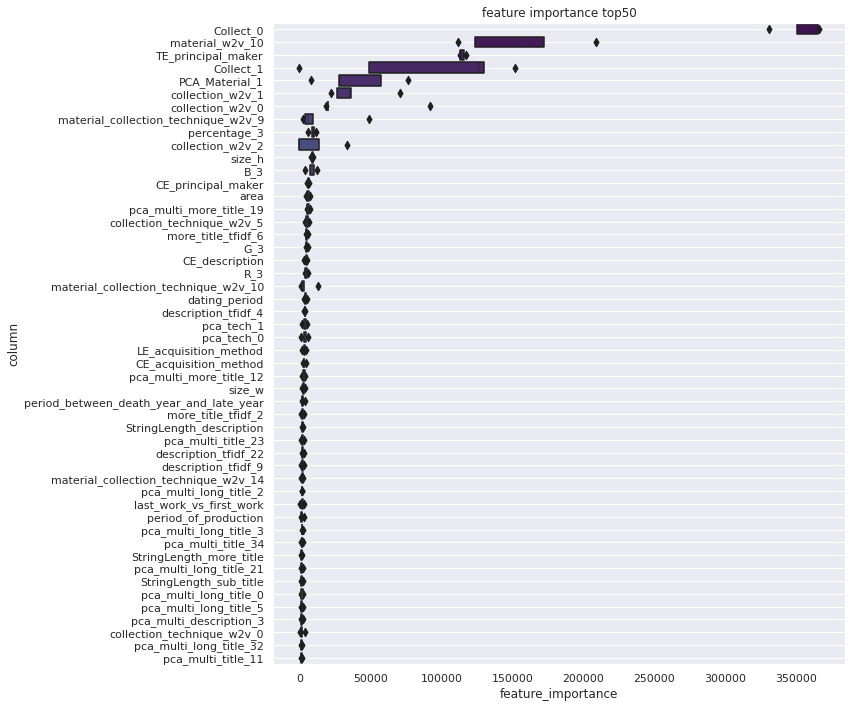

SEED:0, FOLD:0 ------------> val_score:0.8864618216336376
SEED:0, FOLD:1 ------------> val_score:0.8955595890487154
SEED:0, FOLD:2 ------------> val_score:0.9889840492041853
SEED:0, FOLD:3 ------------> val_score:0.9350455022538148
SEED:0, FOLD:4 ------------> val_score:0.94468476223177
SEED:1, FOLD:0 ------------> val_score:0.8864618216336376
SEED:1, FOLD:1 ------------> val_score:0.8955595890487154
SEED:1, FOLD:2 ------------> val_score:0.9889840492041853
SEED:1, FOLD:3 ------------> val_score:0.9350455022538148
SEED:1, FOLD:4 ------------> val_score:0.94468476223177
SEED:2, FOLD:0 ------------> val_score:0.8864618216336376
SEED:2, FOLD:1 ------------> val_score:0.8955595890487154
SEED:2, FOLD:2 ------------> val_score:0.9889840492041853
SEED:2, FOLD:3 ------------> val_score:0.9350455022538148
SEED:2, FOLD:4 ------------> val_score:0.94468476223177
FINISHED| model:bert_feature score:0.9301435123013961



ValueError: ignored

In [76]:
fig, importance_df = model_lgbm.visualize_feature_importance()

In [79]:
select_num = 500
cols = importance_df.groupby("column").mean().reset_index().sort_values('feature_importance', ascending=False)['column'].tolist()
select_cols = cols[:select_num]
train_feat_df = train_feat_df[select_cols]
test_feat_df = test_feat_df[select_cols]

model_lgbm = MyLGBMModel(params=params, name="bert_feature", cv=make_folds, X_train=train_feat_df, y_train=y, X_test=test_feat_df, metrics=mean_squared_error, seeds=[0, 1, 2])

oof_lgbm  = model_lgbm.predict_cv()
oof_preds = model_lgbm.inference()

SEED:0, FOLD:0 ------------> val_score:0.8752223487895611
SEED:0, FOLD:1 ------------> val_score:0.8795537569701425
SEED:0, FOLD:2 ------------> val_score:0.9715992785416133
SEED:0, FOLD:3 ------------> val_score:0.9254428705018061
SEED:0, FOLD:4 ------------> val_score:0.9229341597982211
SEED:1, FOLD:0 ------------> val_score:0.8752223487895611
SEED:1, FOLD:1 ------------> val_score:0.8795537569701425
SEED:1, FOLD:2 ------------> val_score:0.9715992785416133
SEED:1, FOLD:3 ------------> val_score:0.9254428705018061
SEED:1, FOLD:4 ------------> val_score:0.9229341597982211
SEED:2, FOLD:0 ------------> val_score:0.8752223487895611
SEED:2, FOLD:1 ------------> val_score:0.8795537569701425
SEED:2, FOLD:2 ------------> val_score:0.9715992785416133
SEED:2, FOLD:3 ------------> val_score:0.9254428705018061
SEED:2, FOLD:4 ------------> val_score:0.9229341597982211
FINISHED| model:bert_feature score:0.9149471794000517

INFERENCE| -SEED:0, FOLD:0
INFERENCE| -SEED:0, FOLD:1
INFERENCE| -SEED:0, F

In [87]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred

In [88]:
pred = revert_to_real(oof_preds)
sub_df = pd.DataFrame({'likes':pred})

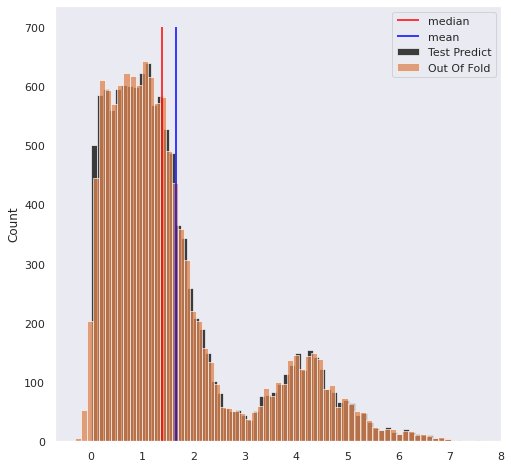

In [90]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(oof_preds, label='Out Of Fold', ax=ax, color='C1')
plt.vlines(np.median(np.log1p(train_df["likes"])), ymin=0, ymax=700, color="red", label="median")
plt.vlines(np.mean(np.log1p(train_df["likes"])), ymin=0, ymax=700, color="blue", label="mean")
ax.legend()
ax.grid()

In [91]:
sub_df.to_csv(OUTPUT_PAHT + "add_bert_feature.csv", index=False)
sub_df.head()

,likes
0,0.549349
1,25.289688
2,0.607996
3,4.628341
4,0.324831


In [95]:
importance_df.sort_values("feature_importance", ascending=True).head(30)

,feature_importance,column,fold
5030,0.0,Álvarez de Toledo Fernando 3e hertog van Alva,3
4889,0.0,pca_multi_acquisition_credit_line_148,3
8464,0.0,Wirix FJ,5
6745,0.0,Wilhelm II keizer van Duitsland,4
5406,0.0,acquisition_credit_line_tfidf_23,4
6747,0.0,Wilhelmina koningin der Nederlanden,4
8462,0.0,Álvarez de Toledo Fernando 3e hertog van Alva,5
8402,0.0,pca_multi_acquisition_credit_line_229,5
3348,0.0,collection_w2v_2,2
8354,0.0,pca_multi_acquisition_credit_line_181,5
